# Домашняя работа

Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Загружаем исходные данные

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

### Визуализируем исходные данные

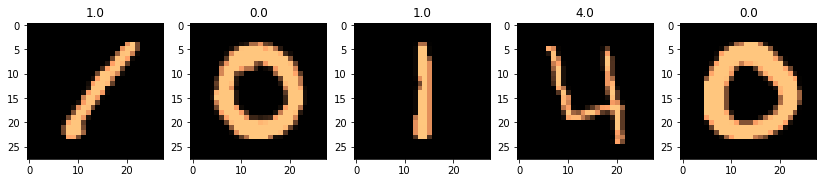

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='copper');
    subplot.set_title('%s' % train_label[i - 1]);

### HOG Descriptor

In [9]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [24]:
# вычисляем гистограммы для каждой картинки
train_hist = np.zeros((len(train_img), 144, 1))
for i in range(len(train_img)):
    train_hist[i] = hog.compute(np.uint8(train_img[i]))

In [27]:
train_hist.shape

(42000, 144, 1)

In [49]:
train_hist = train_hist.reshape(42000,144)

### Визуализируем 1 пример

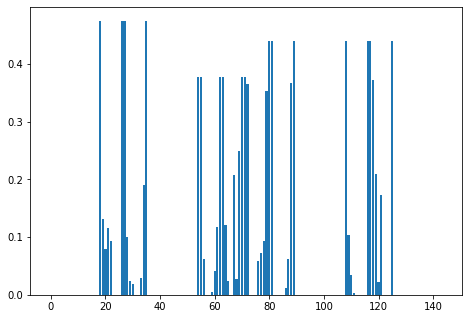

In [103]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(train_hist[2])), train_hist[2].reshape(-1))
plt.show()

### Строим модель KNN

In [51]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
knn = KNeighborsClassifier(n_neighbors=5)

In [54]:
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [57]:
model_score = knn.score(x_val, y_val)

In [59]:
print('Accuracy: %s' % model_score)

Accuracy: 0.9698809523809524


### Предсказания:

In [77]:
y_pred = knn.predict(x_val)

In [114]:
y_pred

array([8., 1., 9., ..., 3., 0., 9.])

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       816
         1.0       0.98      0.99      0.99       909
         2.0       0.98      0.97      0.97       846
         3.0       0.97      0.98      0.97       937
         4.0       0.98      0.95      0.97       839
         5.0       0.99      0.95      0.97       702
         6.0       0.97      0.99      0.98       785
         7.0       0.97      0.95      0.96       893
         8.0       0.96      0.96      0.96       835
         9.0       0.92      0.97      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [79]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[810   0   0   3   0   0   3   0   0   0]
 [  0 900   2   1   1   0   1   1   2   1]
 [  7   2 818   7   1   0   1   1   8   1]
 [  2   0   3 914   1   2   0   3  10   2]
 [  0   4   0   0 801   0   5   6   0  23]
 [  1   0   1  12   4 666  11   0   4   3]
 [  2   2   0   0   0   0 779   0   2   0]
 [  0   2   8   1   4   0   0 845   0  33]
 [  9   3   3   6   2   2   3   1 803   3]
 [  7   1   2   3   0   0   0  10   4 811]]


### Предсказания на тестовых данных

In [115]:
# вычисляем гистограммы для каждой картинки
test_hist = np.zeros((len(test_img), 144, 1))
for i in range(len(test_img)):
    test_hist[i] = hog.compute(np.uint8(test_img[i]))

In [116]:
test_hist.shape

(28000, 144, 1)

In [117]:
test_hist = test_hist.reshape(28000,144)

In [119]:
pred_test = knn.predict(test_hist)

In [120]:
pred_test

array([2., 0., 9., ..., 3., 9., 2.])

### Визуализируем предсказания:

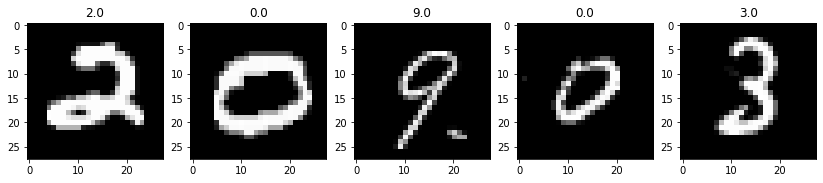

In [122]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i-1]);

### Готовим файл к отправке:

In [129]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))